In [1]:
%matplotlib inline

In [2]:
import pandas
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')

DATA_FILE = 'cs111_svm_dataset.csv'

In [255]:
data = pandas.read_csv(DATA_FILE)
BIAS_COLUMN = 'bias'
LABEL_COLUMN = 'Classification'

data[BIAS_COLUMN] = 1
data[LABEL_COLUMN].replace(0, -1, inplace=True)

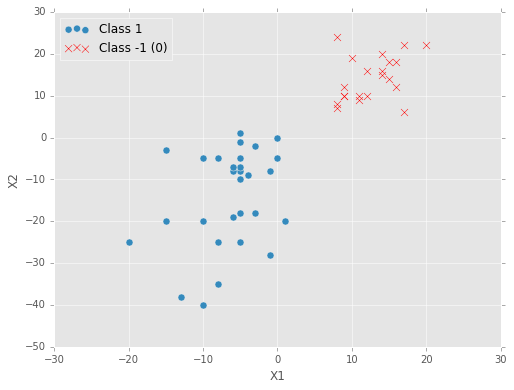

In [245]:
def line_from_theta(theta, x_range):
    b0, b1, b2 = theta
    return -1.0 * (b0 + b1 * x_range) / b2


def plot_data(data, theta=None, title=None):
    ax = data[data[LABEL_COLUMN] == 1].plot(kind='scatter', x='X1', y='X2', marker='o', s=50,
                                                    label='Class 1', figsize=(8, 6))
    data[data[LABEL_COLUMN] == -1].plot(kind='scatter', x='X1', y='X2', marker='x', s=50, 
                                            c='red', label='Class -1 (0)', ax=ax)
    ax.set_xlabel('X1')
    
    if theta is not None:
        x_min = data.min()['X1']
        x_max = data.max()['X1']
        x_range = np.linspace(x_min, x_max)

        ax.plot(x_range, line_from_theta(theta, x_range), color='black', ls='--')
        
    if title:
        ax.set_title(title)
        
    ax.legend(loc=2)
    plt.show()
    
plot_data(data)

In [292]:
DATA_COLUMN_PREFIX = 'X'

def generate_relevant_columns(data, include_bias=True, prefix=DATA_COLUMN_PREFIX):
    columns = data.filter(like=prefix).columns
    if include_bias:
        columns = columns.insert(0, BIAS_COLUMN)
        
    return columns

def loss_function(data, theta, label_column=LABEL_COLUMN, 
                  data_cols_generator=generate_relevant_columns):
    return np.log(1.0 + np.exp(-1.0 * data[label_column] * 
                             data.filter(items=data_cols_generator(data)).values.dot(theta)))


def error_function(data, theta, label_column=LABEL_COLUMN, 
                   data_cols_generator=generate_relevant_columns):
    return np.mean(loss_function(data, theta, label_column, data_cols_generator))
    

def generate_partial_derivatives(label_column=LABEL_COLUMN, 
                                 data_cols_generator=generate_relevant_columns):
    return pandas.concat([-1 * data[label_column] * data[col] 
                          for col in data_cols_generator(data)], axis=1)


def gradient(data, theta, partial_derivatives, 
             label_column=LABEL_COLUMN, 
             data_cols_generator=generate_relevant_columns):
    return partial_derivatives.multiply(1.0 / (
            1.0 + np.exp(data[label_column] * data.filter(items=data_cols_generator(data)).values.dot(theta))), 
                                        axis=0).sum()


GRADIENT_CHECK_STEP = 0.001


def gradient_check(data, theta, step=GRADIENT_CHECK_STEP,
                   label_column=LABEL_COLUMN, 
                   data_cols_generator=generate_relevant_columns):
    """
    Implement gradient checking using the centered formula for the derivative:
    f'(x) = (f(x + h) - f(x - h)) / 2h
    """
    step_configurations = ([step, 0, 0], [0, step, 0], [0, 0, step])
    
    gradients = [(loss_function(data, theta + step_config) - loss_function(data, theta - step_config)) \
            / (2 * step) for step_config in step_configurations]
    
    return [grad.sum() for grad in gradients]


def compare_gradients(step=GRADIENT_CHECK_STEP, label_column=LABEL_COLUMN, 
                      data_cols_generator=generate_relevant_columns):
    test_theta = np.random.random(3)
    partial_derivatives = generate_partial_derivatives(label_column, data_cols_generator)
    
    return gradient_check(data, test_theta, step, label_column, data_cols_generator) - \
            gradient(data, test_theta, partial_derivatives, label_column, data_cols_generator)


LEARNING_RATE = 0.1
DEFAULT_EPOCHS = 1000
DEFAULT_GRAPH_INTERVAL = 10
MIN_DELTA_ERROR = 10 ** -6


def split_data_into_batches(data, batch_size=None):
    if batch_size is None:
        return [data]
    
    if 1 == batch_size:
        return data.sample(frac=1)
    
    shuffled_rows = range(len(data))
    np.random.shuffle(shuffled_rows)
    
    return [data.iloc[shuffled_rows[i * batch_size:(i + 1) * batch_size]] 
            for i in range(len(data) / batch_size)]


def train_model(data, theta=None, batch_size=None, num_epochs=DEFAULT_EPOCHS, 
                learning_rate=LEARNING_RATE, min_delta_error=MIN_DELTA_ERROR, 
                should_print=True, should_graph=False, graph_interval=DEFAULT_GRAPH_INTERVAL,
                label_column=LABEL_COLUMN, data_cols_generator=generate_relevant_columns):
    if batch_size > len(data):
        raise ValueError('Batch size cannot be larger than the entire data. Aborting...')
    
    if theta is None:
        theta = np.random.rand(3)
        
    last_error = float('inf')
    
    partial_derivatives = generate_partial_derivatives(label_column, data_cols_generator)
    
    for i in xrange(num_epochs):
        for batch in split_data_into_batches(data, batch_size):        
            error = error_function(data, theta, label_column, data_cols_generator)
            if should_print:
                print 'In epoch {i} the error is {error}'.format(i=i, error=error)

            if last_error - error < min_delta_error:
                print 'Reached a change in error below the minimum, terminating'
                return theta

            last_error = error

            if should_graph and 0 == i % graph_interval:
                plot_data(data, theta, 'Epoch {i}, error = {error:.4e}'.format(i=i, error=error))

            theta_grad = gradient(data, theta, partial_derivatives, label_column, data_cols_generator)
            theta -= learning_rate * theta_grad
        
    return theta


True
True
In epoch 0 the error is 20.2174500043
True
True
In epoch 0 the error is 9.93686848862e-06
True
True
In epoch 0 the error is 9.93193509785e-06
Reached a change in error below the minimum, terminating


/Users/guydavidson/Virtualenvs/dev/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: overflow encountered in exp


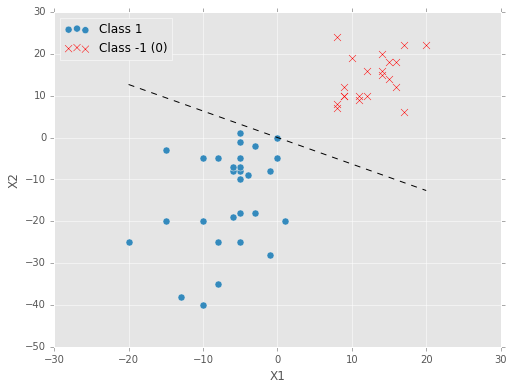

In [289]:
theta = train_model(data, batch_size=10, learning_rate=1)
plot_data(data, theta)

In [298]:
compare_gradients()

0    5.005966e-08
1   -5.663140e-06
2   -4.336831e-06
dtype: float64

In [254]:
c = data.filter(like='X').columns
c.insert(0, 'bias')

Index([u'bias', u'X1', u'X2'], dtype='object')

In [287]:
loss_function(data, theta)

True


0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
20    0.000000
21    0.000000
22    0.000000
23    0.000000
24    0.000000
25    0.000000
26    0.000000
27    0.000000
28    0.000000
29    0.000000
30    0.000000
31    0.000000
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
44    0.000000
45    0.000000
46    0.000000
47    0.000321
48    0.000000
49    0.000000
Name: Classification, dtype: float64

In [280]:
generate_relevant_columns(data, True)

Index([u'X1', u'X2'], dtype='object')